In [1]:
import numpy as np

import cirq
from cirq.contrib.svg import SVGCircuit

In [2]:
exponents = np.linspace(0, 7/4, 8)
exponents

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75])

In [3]:
import itertools
SINGLE_QUBIT_GATES = [
    cirq.PhasedXZGate(x_exponent=0.5, z_exponent=z, axis_phase_exponent=a)
    for a, z in itertools.product(exponents, repeat=2)
]
SINGLE_QUBIT_GATES[:10], '...'

([cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.0),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.25),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.5),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.75),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.0),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.25),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.5),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.75),
  cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=0.5, z_exponent=0.0),
  cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=0.5, z_exponent=0.25)],
 '...')

In [4]:
import cirq_google as cg
from cirq.experiments import random_quantum_circuit_generation as rqcg

q0, q1 = cirq.LineQubit.range(2)

In [5]:
n_circuits = 10
circuits = [
    rqcg.random_rotations_between_two_qubit_circuit(
        q0, q1, 
        depth=100, 
        two_qubit_op_factory=lambda a, b, _: cirq.SQRT_ISWAP(a, b), 
        single_qubit_gates=SINGLE_QUBIT_GATES)
    for _ in range(n_circuits)
]

In [6]:
max_depth = 100
cycle_depths = np.arange(3, max_depth, 9)
cycle_depths

array([ 3, 12, 21, 30, 39, 48, 57, 66, 75, 84, 93])

In [7]:
# emulate coherent error
sqrt_iswap_as_phased_fsim = cirq.PhasedFSimGate.from_fsim_rz(
    theta=-np.pi/4, phi=0, 
    rz_angles_before=(0,0), rz_angles_after=(0,0))
np.testing.assert_allclose(
    cirq.unitary(sqrt_iswap_as_phased_fsim),
    cirq.unitary(cirq.SQRT_ISWAP),
    atol=1e-8
)

In [8]:
# perturbed version
perturbed_sqrt_iswap = cirq.PhasedFSimGate.from_fsim_rz(theta=-np.pi/4, phi=np.pi/16,
                                                        rz_angles_before=(0,0), rz_angles_after=(0,0))
np.round(cirq.unitary(perturbed_sqrt_iswap), 3)

array([[1.   +0.j   , 0.   +0.j   , 0.   +0.j   , 0.   +0.j   ],
       [0.   +0.j   , 0.707+0.j   , 0.   +0.707j, 0.   +0.j   ],
       [0.   +0.j   , 0.   +0.707j, 0.707+0.j   , 0.   +0.j   ],
       [0.   +0.j   , 0.   +0.j   , 0.   +0.j   , 0.981-0.195j]])

In [9]:
# simulator with constant coherent error
def _sub_iswap(op):
    if op.gate == cirq.SQRT_ISWAP:
        return perturbed_sqrt_iswap.on(*op.qubits)
    return op

noise = cirq.devices.noise_model.GateSubstitutionNoiseModel(_sub_iswap)
noisy_sim = cirq.DensityMatrixSimulator(noise=noise)

In [10]:
# run benchmark circuits
from cirq.experiments.xeb_sampling import sample_2q_xeb_circuits
sampled_df = sample_2q_xeb_circuits(sampler=noisy_sim, circuits=circuits, 
                                    cycle_depths=cycle_depths, repetitions=10_000)
sampled_df.head()

100%|███████████████████████████████████████████████████████████| 117/117 [00:20<00:00,  5.61it/s]


,,sampled_probs,timestamp,pair
circuit_i,cycle_depth,,,
0,3,"[0.346, 0.2142, 0.1322, 0.3076]",1.636054e+09,"(0, 1)"
1,3,"[0.0295, 0.3115, 0.0909, 0.5681]",1.636054e+09,"(0, 1)"
2,3,"[0.5147, 0.0762, 0.2651, 0.144]",1.636054e+09,"(0, 1)"
3,3,"[0.1765, 0.0541, 0.4791, 0.2903]",1.636054e+09,"(0, 1)"
4,3,"[0.073, 0.0638, 0.26, 0.6032]",1.636054e+09,"(0, 1)"


In [11]:
# compute fidelity
from cirq.experiments.xeb_fitting import benchmark_2q_xeb_fidelities
fids = benchmark_2q_xeb_fidelities(sampled_df, circuits, cycle_depths)
fids.head()

,cycle_depth,fidelity,pair
0,3,0.926900,"(0, 1)"
1,12,0.856284,"(0, 1)"
2,21,0.774688,"(0, 1)"
3,30,0.632738,"(0, 1)"
4,39,0.586245,"(0, 1)"


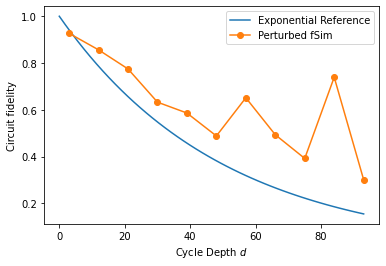

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

xx = np.linspace(0, fids['cycle_depth'].max())
plt.plot(xx, (1-5e-3)**(4*xx), label=r'Exponential Reference')

plt.plot(fids['cycle_depth'], fids['fidelity'], 'o-', label='Perturbed fSim')

plt.ylabel('Circuit fidelity')
plt.xlabel('Cycle Depth $d$')
plt.legend(loc='best')

In [13]:
# optimize parameters
import multiprocessing
pool = multiprocessing.get_context('spawn').Pool()
from cirq.experiments.xeb_fitting import \
    parameterize_circuit, characterize_phased_fsim_parameters_with_xeb, SqrtISwapXEBOptions

options = SqrtISwapXEBOptions(
    characterize_theta=True, 
    characterize_phi=True,
    characterize_chi=False,
    characterize_gamma=False,
    characterize_zeta=False
)
p_circuits = [parameterize_circuit(circuit, options) for circuit in circuits]
res = characterize_phased_fsim_parameters_with_xeb(
    sampled_df, 
    p_circuits, 
    cycle_depths, 
    options, 
    pool=pool,
    xatol=1e-3,
    fatol=1e-3)

Simulating with theta =  -0.785 phi   =       0 
Loss:   0.378
Simulating with theta =  -0.685 phi   =       0 
Loss:   0.592
Simulating with theta =  -0.785 phi   =     0.1 
Loss:  0.0991
Simulating with theta =  -0.885 phi   =     0.1 
Loss:   0.249
Simulating with theta =  -0.885 phi   =     0.2 
Loss:   0.245
Simulating with theta =  -0.785 phi   =     0.2 
Loss: 0.00168
Simulating with theta =  -0.735 phi   =    0.25 
Loss:   0.101
Simulating with theta =  -0.685 phi   =     0.1 
Loss:   0.389
Simulating with theta =  -0.835 phi   =   0.175 
Loss:  0.0685
Simulating with theta =  -0.835 phi   =   0.275 
Loss:   0.144
Simulating with theta =  -0.798 phi   =   0.144 
Loss:  0.0213
Simulating with theta =  -0.748 phi   =   0.169 
Loss:   0.071
Simulating with theta =  -0.814 phi   =   0.173 
Loss:   0.021
Simulating with theta =  -0.801 phi   =    0.23 
Loss:  0.0303
Simulating with theta =  -0.799 phi   =   0.165 
Loss: 0.00753
Simulating with theta =  -0.771 phi   =   0.192 
Loss: 

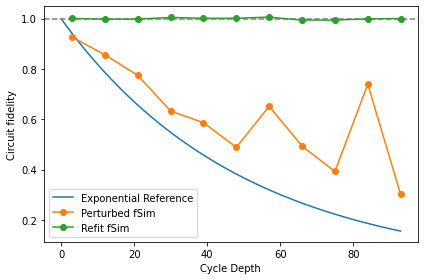

In [14]:
xx = np.linspace(0, fids['cycle_depth'].max())
p_depol = 5e-3 # from above
plt.plot(xx, (1-p_depol)**(4*xx), label=r'Exponential Reference')
plt.axhline(1, color='grey', ls='--')

plt.plot(fids['cycle_depth'], fids['fidelity'], 'o-', label='Perturbed fSim')
plt.plot(res.fidelities_df['cycle_depth'], res.fidelities_df['fidelity'], 'o-', label='Refit fSim')

plt.ylabel('Circuit fidelity')
plt.xlabel('Cycle Depth')
plt.legend(loc='best')
plt.tight_layout()